In [1]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import ipdb as pdb
import time

for k in range(5):
    
    print('---------' + str(k) + '------------')
    
    MAX_EPISODE = 100
    MAX_EPISODE_LEN = 10000

    NUM_T = 1
    NUM_R = 4
    SIGMA2 = 1e-9

    t_factor = 0.5
    noise_sigma = 0.12

    config = {'state_dim':3, 'action_dim':2};
    train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                    'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                    'random_seed':int(time.clock()*1000%1000), 'noise_sigma':noise_sigma, 'sigma2':SIGMA2}
    
#     rate = 2.0
    res_path = 't_nB_LGD/'
    model_path = 'model_M_r40_nB_dqn/my_train_model_'+str(k)+'-2000'
    meta_path = model_path+'.meta'
    init_path = ''
    user_config = [{'id':'1', 'model':'AR', 'num_r':NUM_R, 'rate':1.0, 'dis':50, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000, 'action_level':5},
                   {'id':'2', 'model':'AR', 'num_r':NUM_R, 'rate':2.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000, 'action_level':5},
                   {'id':'3', 'model':'AR', 'num_r':NUM_R, 'rate':3.0, 'dis':150, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000, 'action_level':5}]

    if not os.path.exists(res_path):
        os.mkdir(res_path) 
        
    print(user_config)

    # 1. include all user in the system according to the user_config
    user_list = [];
    for info in user_config:
        info.update(config)
        user_list.append(MecTermGD_M(info, train_config, 'local'))
        print('Initialization OK!----> user ' + info['id'])

    # 2. create the simulation env
    env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)

    # #Create a saver object which will save all the variables
    # saver = tf.train.Saver() 

    res_r = []
    res_p = []
    res_b = []
    res_o = []
    res_d = []
    # 3. start to explore for each episode
    for i in range(MAX_EPISODE):

        cur_init_ds_ep = env.reset(isTrain=False)

        cur_r_ep = np.zeros(len(user_list))
        cur_p_ep = np.zeros(len(user_list))
        cur_op_ep = np.zeros(len(user_list))
        cur_ts_ep = np.zeros(len(user_list))
        cur_ps_ep = np.zeros(len(user_list))
        cur_rs_ep = np.zeros(len(user_list))
        cur_ds_ep = np.zeros(len(user_list))
        cur_ch_ep = np.zeros(len(user_list))
        cur_of_ep = np.zeros(len(user_list))

        for j in range(MAX_EPISODE_LEN):
            
            # first try to transmit from current state
            [cur_r, done, cur_p, cur_op, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()

            cur_r_ep += cur_r
            cur_p_ep += cur_p
            cur_op_ep += cur_op
            cur_ts_ep += cur_ts
            cur_ps_ep += cur_ps
            cur_rs_ep += cur_rs
            cur_ds_ep += cur_ds
            cur_ch_ep += cur_ch
            cur_of_ep += cur_of


            if done:
                res_r.append(cur_r_ep/MAX_EPISODE_LEN)
                res_p.append(cur_p_ep/MAX_EPISODE_LEN)
                res_b.append(cur_ds_ep/MAX_EPISODE_LEN)
                res_o.append(cur_of_ep/MAX_EPISODE_LEN)
                res_d.append(cur_ds)
                print('%d:r:%s,p:%s,op:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s,rbuf:%s' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_op_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep, cur_ds))

    name = res_path+'test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
    np.savez(name, res_r, res_p, res_b, res_o, res_d)
    


---------0------------
[{'penalty': 1000, 'num_r': 4, 'rate': 1.0, 'action_bound': 2, 'data_buf_size': 100, 'action_level': 5, 'model': 'AR', 'id': '1', 't_factor': 0.5, 'dis': 50}, {'penalty': 1000, 'num_r': 4, 'rate': 2.0, 'action_bound': 2, 'data_buf_size': 100, 'action_level': 5, 'model': 'AR', 'id': '2', 't_factor': 0.5, 'dis': 100}, {'penalty': 1000, 'num_r': 4, 'rate': 3.0, 'action_bound': 2, 'data_buf_size': 100, 'action_level': 5, 'model': 'AR', 'id': '3', 't_factor': 0.5, 'dis': 150}]
Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[ -2.52790746  -7.64911369 -18.2041011 ],p:[0.4041964  1.31833191 3.07435752],op:[0. 0. 0.],tr:[0.06212884 0.35523005 0.69103442],pr:[0.95317978 1.68037657 2.29391203],rev:[1.0065 2.003  2.9725],dbuf:[1.01385089 2.11490825 5.66462699],ch:[31.73305847  3.8228957   1.22106531],ibuf:[0, 0, 0],rbuf:[1.         1.         9.88329317]
1:r:[ -2.5139933   -7.49676352 -18.63358651],p:[0.40214702 1.29023506 3.

23:r:[ -2.50800209  -7.58956742 -18.20618919],p:[0.40078642 1.307282   3.09303623],op:[0. 0. 0.],tr:[0.0697172  0.35832551 0.70038535],pr:[0.94188725 1.67874799 2.29852881],rev:[1.0007 2.0053 2.9849],dbuf:[1.00814002 2.10631486 5.48201606],ch:[32.58175149  3.99992506  1.22292188],ibuf:[0, 0, 0],rbuf:[2.         3.17006967 1.        ]
24:r:[ -2.51395263  -7.54580689 -19.02808773],p:[0.40212293 1.29983263 3.16993244],op:[0. 0. 0.],tr:[0.06332924 0.35082661 0.69759327],pr:[0.94636708 1.67832984 2.31799138],rev:[0.9994 1.9967 3.0045],dbuf:[1.00667599 2.09328747 6.35685107],ch:[31.89047213  3.98276357  1.14635885],ibuf:[0, 0, 0],rbuf:[0.         1.         7.55901552]
25:r:[ -2.57482499  -7.62519277 -18.64505955],p:[0.4130243  1.31473418 3.13255319],op:[0. 0. 0.],tr:[0.06706902 0.35399735 0.69587229],pr:[0.95680898 1.68298919 2.30586701],rev:[1.0124 2.0033 2.9893],dbuf:[1.01940699 2.10304373 5.96458719],ch:[32.74411007  4.04870156  1.17867281],ibuf:[0, 0, 0],rbuf:[4.16333634e-17 1.00000000e

48:r:[ -2.57632058  -7.56811477 -18.68406391],p:[0.4130773  1.30359054 3.11819704],op:[0. 0. 0.],tr:[0.07020765 0.36069408 0.70614235],pr:[0.95565133 1.67617038 2.30456152],rev:[1.0149 2.0036 2.9996],dbuf:[1.02186821 2.10032411 6.1861574 ],ch:[30.75002016  4.02840188  1.21848663],ibuf:[0, 0, 0],rbuf:[3.         4.15194698 8.17177017]
49:r:[ -2.45676758  -7.63602473 -19.26276152],p:[0.39240642 1.31668309 3.21032087],op:[0. 0. 0.],tr:[0.06401977 0.360125   0.72303891],pr:[0.92947244 1.67777402 2.32863778],rev:[0.9824 2.0046 3.0408],dbuf:[0.98947098 2.10521856 6.42231434],ch:[31.02174814  3.91532648  1.18543621],ibuf:[0, 0, 0],rbuf:[1.         1.         4.87585861]
50:r:[ -2.51695919  -7.52209477 -18.71962447],p:[0.40276306 1.29595002 3.13035057],op:[0. 0. 0.],tr:[0.06379128 0.3552881  0.6979809 ],pr:[0.94584143 1.67067076 2.31006755],rev:[0.9987 1.9926 2.9955],dbuf:[1.00628777 2.0846893  6.13574327],ch:[31.61704357  4.07918341  1.18588745],ibuf:[0, 0, 0],rbuf:[9.99200722e-16 3.00000000e

73:r:[ -2.52233517  -7.72709117 -17.93397177],p:[0.40358794 1.3320405  3.06403189],op:[0. 0. 0.],tr:[0.07127554 0.36731313 0.68890622],pr:[0.9416647  1.68785661 2.29251082],rev:[1.0013 2.0228 2.9677],dbuf:[1.00879093 2.13377733 5.22762463],ch:[30.88181375  3.97175419  1.22878516],ibuf:[0, 0, 0],rbuf:[2.         1.         5.20807943]
74:r:[ -2.55546741  -7.65698943 -18.7521044 ],p:[0.4094392  1.31940183 3.149347  ],op:[0. 0. 0.],tr:[0.0752005  0.36168948 0.68391335],pr:[0.94727953 1.68417231 2.31288141],rev:[1.0092 2.0109 2.9849],dbuf:[1.0165428  2.11996057 6.01073879],ch:[32.64293413  4.07640563  1.17009852],ibuf:[0, 0, 0],rbuf:[9.99200722e-16 2.22044605e-15 4.18086995e+00]
75:r:[ -2.53802766  -7.61854403 -18.85991651],p:[0.40631377 1.31342672 3.15595045],op:[0. 0. 0.],tr:[0.06605889 0.35401809 0.68007384],pr:[0.95028728 1.68183829 2.31842298],rev:[1.0058 2.0052 2.9867],dbuf:[1.01291762 2.10282087 6.16032848],ch:[32.99155537  3.91566254  1.11885802],ibuf:[0, 0, 0],rbuf:[0. 5. 6.]
76:r

98:r:[ -2.47982489  -7.73488289 -18.25594404],p:[0.39648103 1.33373639 3.0953186 ],op:[0. 0. 0.],tr:[0.06924239 0.36637544 0.708401  ],pr:[0.92936281 1.68983604 2.30586691],rev:[0.9876 2.0226 3.0018],dbuf:[0.99483953 2.13240191 5.55870205],ch:[33.04911642  3.86281533  1.240482  ],ibuf:[0, 0, 0],rbuf:[3.        3.        8.9476088]
99:r:[ -2.52691032  -7.57456989 -18.90433402],p:[0.40485151 1.30537717 3.16732161],op:[0. 0. 0.],tr:[0.07024401 0.34769538 0.68892089],pr:[0.9376402  1.67217658 2.31701638],rev:[0.9964 1.987  2.9944],dbuf:[1.00530551 2.0953681  6.13545192],ch:[31.17608667  3.97810688  1.17846103],ibuf:[0, 0, 0],rbuf:[9.99200722e-16 3.00000000e+00 5.34181196e+00]
---------1------------
[{'penalty': 1000, 'num_r': 4, 'rate': 1.0, 'action_bound': 2, 'data_buf_size': 100, 'action_level': 5, 'model': 'AR', 'id': '1', 't_factor': 0.5, 'dis': 50}, {'penalty': 1000, 'num_r': 4, 'rate': 2.0, 'action_bound': 2, 'data_buf_size': 100, 'action_level': 5, 'model': 'AR', 'id': '2', 't_facto

21:r:[ -2.50821015  -7.62751413 -18.88296184],p:[0.4009791  1.31460746 3.17743448],op:[0. 0. 0.],tr:[0.06523622 0.35723777 0.70607628],pr:[0.94512433 1.67995791 2.32268207],rev:[0.9998 2.0041 3.0181],dbuf:[1.0066293  2.10895368 5.99157886],ch:[32.27343688  3.95343456  1.15854154],ibuf:[0, 0, 0],rbuf:[ 2.          4.         19.40929571]
22:r:[ -2.53974805  -7.60069486 -18.25650205],p:[0.40639688 1.30937008 3.10446566],op:[0. 0. 0.],tr:[0.06452578 0.35712044 0.695007  ],pr:[0.95430759 1.67858958 2.30368011],rev:[1.0083 2.0041 2.9844],dbuf:[1.01552726 2.10768895 5.4683475 ],ch:[31.78440357  4.01401646  1.20034418],ibuf:[0, 0, 0],rbuf:[1.00000000e+00 1.11022302e-15 3.28897826e+00]
23:r:[ -2.52621532  -7.5155837  -18.09938048],p:[0.40421195 1.2948864  3.08102729],op:[0. 0. 0.],tr:[0.06769298 0.35138908 0.6845231 ],pr:[0.94597907 1.66904019 2.29055525],rev:[1.0027 1.9885 2.9627],dbuf:[1.01031114 2.0823034  5.388488  ],ch:[31.31266399  3.92210439  1.15270797],ibuf:[0, 0, 0],rbuf:[2. 3. 7.]
2

46:r:[ -2.48667125  -7.58443674 -19.24793818],p:[0.39797754 1.30617069 3.20498295],op:[0. 0. 0.],tr:[0.06667936 0.35599612 0.72994474],pr:[0.93109408 1.68141433 2.33125739],rev:[0.9866 2.0056 3.0495],dbuf:[0.99356708 2.10716655 6.44604684],ch:[31.72849134  4.09865644  1.19316701],ibuf:[0, 0, 0],rbuf:[0. 0. 3.]
47:r:[ -2.60189096  -7.83560774 -18.59467069],p:[0.4171018  1.35111272 3.12328886],op:[0. 0. 0.],tr:[0.06944708 0.37631192 0.69249115],pr:[0.96872774 1.69793282 2.30356595],rev:[1.0256 2.0409 2.9855],dbuf:[1.03276396 2.16008824 5.95645274],ch:[31.59358881  4.0348631   1.17746903],ibuf:[0, 0, 0],rbuf:[1.00000000e+00 1.11022302e-15 8.79811434e+00]
48:r:[ -2.48694635  -7.51798675 -18.16251684],p:[0.39769314 1.29455095 3.08086385],op:[0. 0. 0.],tr:[0.06520766 0.34469662 0.68912356],pr:[0.93644805 1.6788346  2.29871641],rev:[0.9903 1.9907 2.9755],dbuf:[0.99696133 2.09046401 5.51639514],ch:[32.57019964  4.07958647  1.20510792],ibuf:[0, 0, 0],rbuf:[ 1.        2.       16.106159]
49:r:[ 

71:r:[ -2.52515685  -7.62195035 -19.03964315],p:[0.40354977 1.31347423 3.17368523],op:[0. 0. 0.],tr:[0.07010642 0.35483881 0.70674058],pr:[0.94825527 1.67922136 2.31908504],rev:[1.007  2.0024 3.0146],dbuf:[1.01481604 2.10915838 6.342434  ],ch:[33.06423804  3.96383765  1.16917211],ibuf:[0, 0, 0],rbuf:[4.04040011 6.         7.04383976]
72:r:[ -2.53620189  -7.52888952 -18.6993403 ],p:[0.40595349 1.29780589 3.15148467],op:[0. 0. 0.],tr:[0.06806326 0.342691   0.71457202],pr:[0.95026481 1.66786916 2.31274356],rev:[1.0057 1.9781 3.0159],dbuf:[1.01286892 2.07972019 5.88383384],ch:[31.51036136  3.93559745  1.22375619],ibuf:[0, 0, 0],rbuf:[0.         1.         9.60956168]
73:r:[ -2.54863691  -7.6582569  -18.47429011],p:[0.40828261 1.32056572 3.12779016],op:[0. 0. 0.],tr:[0.06872056 0.35349831 0.69916562],pr:[0.94980089 1.68553597 2.31209136],rev:[1.0065 2.0061 2.9988],dbuf:[1.01444775 2.11085664 5.67067866],ch:[30.82325361  4.05052108  1.20147837],ibuf:[0, 0, 0],rbuf:[1.         2.         8.67

96:r:[ -2.59035802  -7.49092699 -18.52233467],p:[0.41486764 1.29009504 3.125357  ],op:[0. 0. 0.],tr:[0.06882804 0.35370341 0.7005282 ],pr:[0.96539255 1.66070285 2.30096092],rev:[1.0242 1.9814 2.9902],dbuf:[1.0320397  2.08090354 5.79109937],ch:[31.00017332  4.00441153  1.17857277],ibuf:[0, 0, 0],rbuf:[ 1.          1.46233306 11.16131064]
97:r:[ -2.50326546  -7.47119305 -18.32125079],p:[0.40062912 1.2862348  3.10276073],op:[0. 0. 0.],tr:[0.06499851 0.34529644 0.68705508],pr:[0.94039586 1.66414834 2.30809745],rev:[0.9933 1.9767 2.9814],dbuf:[1.00023969 2.08003809 5.61489433],ch:[31.20156479  4.10334574  1.17693116],ibuf:[0, 0, 0],rbuf:[2.22044605e-15 0.00000000e+00 1.12812653e+01]
98:r:[ -2.5027553   -7.63593479 -19.1834768 ],p:[0.39996239 1.31610865 3.1943803 ],op:[0. 0. 0.],tr:[0.06130208 0.35928696 0.71798196],pr:[0.94756388 1.68851833 2.32555361],rev:[0.9991 2.0142 3.0317],dbuf:[1.00588672 2.11078304 6.4231506 ],ch:[32.54912122  4.10173064  1.18913376],ibuf:[0, 0, 0],rbuf:[9.99200722e

19:r:[ -2.54258424  -7.60943811 -18.32681676],p:[0.40712626 1.31066847 3.10525592],op:[0. 0. 0.],tr:[0.06568504 0.34913445 0.69505877],pr:[0.9517347  1.67776399 2.30054122],rev:[1.0061 1.995  2.9838],dbuf:[1.0139059  2.1121915  5.60107432],ch:[31.31942324  4.05382032  1.18757265],ibuf:[0, 0, 0],rbuf:[9.99200722e-16 5.00000000e+00 4.83676363e+00]
20:r:[ -2.48251398  -7.48560211 -18.36166107],p:[0.39682569 1.2899087  3.10563618],op:[0. 0. 0.],tr:[0.06448081 0.34231177 0.66829556],pr:[0.93582593 1.66758909 2.3001568 ],rev:[0.9901 1.9782 2.9563],dbuf:[0.99677106 2.07211719 5.6669603 ],ch:[32.15463195  3.94904495  1.135775  ],ibuf:[0, 0, 0],rbuf:[2.22044605e-15 3.00000000e+00 2.00000000e+00]
21:r:[ -2.58979646  -7.65710522 -18.71091073],p:[0.4154533  1.31944322 3.16255629],op:[0. 0. 0.],tr:[0.0692363  0.36091362 0.69757101],pr:[0.96049514 1.68613199 2.31919495],rev:[1.018  2.014  3.0045],dbuf:[1.02505989 2.11977824 5.7962586 ],ch:[31.65187654  3.97359611  1.18074371],ibuf:[0, 0, 0],rbuf:[2.

44:r:[ -2.50398387  -7.62465322 -19.19189752],p:[0.40022422 1.31380101 3.19163554],op:[0. 0. 0.],tr:[0.06168476 0.36065025 0.7095259 ],pr:[0.94566154 1.68403671 2.32813993],rev:[0.998  2.0102 3.0257],dbuf:[1.00572553 2.11129634 6.46743963],ch:[32.19684972  4.12355781  1.20118002],ibuf:[0, 0, 0],rbuf:[2.00000000e+00 1.11022302e-15 1.35387896e+00]
45:r:[ -2.57091935  -7.87000204 -18.88141758],p:[0.41215177 1.35917562 3.17905039],op:[0. 0. 0.],tr:[0.06955641 0.36650689 0.68186128],pr:[0.95438582 1.69459814 2.31415989],rev:[1.0123 2.0277 2.9848],dbuf:[1.02032101 2.14824785 5.97233132],ch:[32.89475979  3.91584933  1.12277526],ibuf:[0, 0, 0],rbuf:[1. 1. 2.]
46:r:[ -2.47193963  -7.42916155 -18.17891225],p:[0.39477448 1.27795824 3.09381042],op:[0. 0. 0.],tr:[0.06330305 0.34748658 0.6850135 ],pr:[0.93572563 1.6681177  2.29993447],rev:[0.9891 1.9835 2.9729],dbuf:[0.99613447 2.07874065 5.41972032],ch:[30.41596972  4.11420334  1.18811532],ibuf:[0, 0, 0],rbuf:[3.         3.         5.61226239]
47:r

69:r:[ -2.50294862  -7.60261537 -18.95295851],p:[0.40021253 1.31088286 3.15148181],op:[0. 0. 0.],tr:[0.06642202 0.34875625 0.69995431],pr:[0.94072533 1.67600477 2.31407818],rev:[0.9967 1.9915 3.0025],dbuf:[1.00377198 2.09640209 6.39109888],ch:[33.27091289  3.99354205  1.20297562],ibuf:[0, 0, 0],rbuf:[ 1.          0.         10.21941267]
70:r:[ -2.50232768  -7.65023971 -18.66831314],p:[0.39985754 1.31919155 3.13585226],op:[0. 0. 0.],tr:[0.06844728 0.34817677 0.69040224],pr:[0.94073851 1.67686796 2.31065813],rev:[0.9986 1.9937 2.9883],dbuf:[1.00608    2.10856396 5.97810366],ch:[32.13065281  3.88722429  1.17283962],ibuf:[0, 0, 0],rbuf:[2.00000000e+00 9.99200722e-16 3.00000000e+00]
71:r:[ -2.52647171  -7.59380483 -18.23787394],p:[0.40396313 1.30832982 3.09514086],op:[0. 0. 0.],tr:[0.06749883 0.36377679 0.69696984],pr:[0.94899767 1.67501351 2.3007534 ],rev:[1.0058 2.0054 2.985 ],dbuf:[1.01331214 2.10431144 5.52433929],ch:[32.26239679  4.05383736  1.20296402],ibuf:[0, 0, 0],rbuf:[1.11022302e

94:r:[ -2.4103366   -7.66383194 -18.39571542],p:[0.38427456 1.32159105 3.111904  ],op:[0. 0. 0.],tr:[0.05726883 0.35632028 0.7015922 ],pr:[0.92369394 1.68023312 2.30458186],rev:[0.9715 2.0052 2.9923],dbuf:[0.97792757 2.11175334 5.67239089],ch:[32.97514117  3.98671375  1.19377488],ibuf:[0, 0, 0],rbuf:[2.22044605e-15 1.00000000e+00 2.04968516e+00]
95:r:[ -2.52662795  -7.45129414 -18.37945322],p:[0.40446047 1.28200719 3.11408899],op:[0. 0. 0.],tr:[0.06650381 0.35182571 0.69182756],pr:[0.94487712 1.6627531  2.30604956],rev:[1.0012 1.9822 2.9868],dbuf:[1.00865118 2.08251633 5.61801651],ch:[32.68672673  4.11270239  1.1687275 ],ibuf:[0, 0, 0],rbuf:[2.00000000e+00 2.66453526e-15 1.00390593e+01]
96:r:[ -2.52265392  -7.51852076 -18.54941143],p:[0.40326392 1.29443753 3.14328945],op:[0. 0. 0.],tr:[0.07060906 0.35354842 0.71111625],pr:[0.94650555 1.67432358 2.31299748],rev:[1.0061 1.9958 3.0108],dbuf:[1.01266866 2.09266617 5.66592832],ch:[30.98283159  4.05973779  1.22179213],ibuf:[0, 0, 0],rbuf:[3.

17:r:[ -2.53687531  -7.56324048 -18.56431657],p:[0.40644374 1.30295206 3.11833649],op:[0. 0. 0.],tr:[0.06381282 0.35363739 0.69896289],pr:[0.94832587 1.67269888 2.30185998],rev:[1.002  1.9926 2.9867],dbuf:[1.00931317 2.0969604  5.94526821],ch:[31.68441278  4.07309106  1.20389137],ibuf:[0, 0, 0],rbuf:[2.         3.         5.16311205]
18:r:[ -2.60200685  -7.68339798 -18.90611422],p:[0.41780304 1.32431157 3.18151446],op:[0. 0. 0.],tr:[0.07152447 0.35658022 0.70089274],pr:[0.96016563 1.68924687 2.32362902],rev:[1.0187 2.0132 3.0136],dbuf:[1.02598325 2.12368023 5.99708388],ch:[33.23718947  3.89848145  1.17353292],ibuf:[0, 0, 0],rbuf:[ 2.          2.         12.13714358]
19:r:[ -2.47098655  -7.4510591  -18.95584344],p:[0.39480695 1.28262978 3.18142736],op:[0. 0. 0.],tr:[0.06429232 0.34672717 0.71072755],pr:[0.93311831 1.67462949 2.32902969],rev:[0.9862 1.987  3.0283],dbuf:[0.99390361 2.07582036 6.09741332],ch:[32.67783022  4.0991498   1.18272371],ibuf:[0, 0, 0],rbuf:[1.         3.43638765 8

42:r:[ -2.59815374  -7.53261621 -18.49817007],p:[0.41619966 1.29887317 3.09689463],op:[0. 0. 0.],tr:[0.06738143 0.34875368 0.70334505],pr:[0.97042142 1.66952463 2.30553439],rev:[1.0269 1.9836 2.9968],dbuf:[1.03431086 2.07650076 6.02739379],ch:[31.00344141  3.8970109   1.22448415],ibuf:[0, 0, 0],rbuf:[ 2.          3.         15.81988528]
43:r:[ -2.50353075  -7.65185013 -19.07239379],p:[0.4004621  1.31915924 3.185494  ],op:[0. 0. 0.],tr:[0.06672096 0.35555903 0.69893721],pr:[0.93988175 1.68039888 2.3200856 ],rev:[0.9956 2.0039 3.0068],dbuf:[1.00244047 2.11210784 6.28984757],ch:[32.03526781  4.0296333   1.1653625 ],ibuf:[0, 0, 0],rbuf:[1.         4.         6.09960994]
44:r:[ -2.56220813  -7.63496334 -18.76679215],p:[0.4105266  1.31591613 3.15589242],op:[0. 0. 0.],tr:[0.06875389 0.36038456 0.68903132],pr:[0.95379229 1.68015497 2.30923422],rev:[1.0113 2.0063 2.9879],dbuf:[1.01915021 2.1107654  5.9746601 ],ch:[31.21718935  3.9927796   1.1448217 ],ibuf:[0, 0, 0],rbuf:[2.22044605e-15 3.000000

67:r:[ -2.49683682  -7.46573408 -18.55636637],p:[0.39940475 1.28426669 3.1227764 ],op:[0. 0. 0.],tr:[0.06103521 0.34488652 0.70257219],pr:[0.94162085 1.67107222 2.30898852],rev:[0.9925 1.9842 2.9995],dbuf:[0.99962612 2.08880131 5.88496869],ch:[32.81855817  4.12724074  1.1977745 ],ibuf:[0, 0, 0],rbuf:[ 1.          3.06418373 12.17364748]
68:r:[ -2.54575271  -7.53035273 -18.11251546],p:[0.40802769 1.29663448 3.0777201 ],op:[0. 0. 0.],tr:[0.06762637 0.34964313 0.68789069],pr:[0.94809206 1.67101284 2.29835384],rev:[1.0045 1.9882 2.9722],dbuf:[1.01122851 2.09436065 5.44782994],ch:[30.72272534  3.89190611  1.21550348],ibuf:[0, 0, 0],rbuf:[2.         4.         4.62685127]
69:r:[ -2.52103308  -7.60821329 -18.73170875],p:[0.40278784 1.31047737 3.14553255],op:[0. 0. 0.],tr:[0.07016729 0.3648615  0.70804098],pr:[0.9481555  1.67498671 2.31063484],rev:[1.007  2.0053 3.0077],dbuf:[1.01418781 2.11165287 6.00809195],ch:[32.50283407  4.0510667   1.19378824],ibuf:[0, 0, 0],rbuf:[2.         1.         8

92:r:[ -2.61509196  -7.73938275 -18.57125461],p:[0.41967713 1.33476934 3.13230807],op:[0. 0. 0.],tr:[0.06849368 0.36686639 0.69975606],pr:[0.96976587 1.68760478 2.30952817],rev:[1.0257 2.0202 2.9962],dbuf:[1.03341266 2.1310721  5.81942856],ch:[32.29633965  3.99676625  1.197171  ],ibuf:[0, 0, 0],rbuf:[1.11022302e-15 4.00000000e+00 1.08702571e+00]
93:r:[ -2.51626284  -7.69606382 -18.96371157],p:[0.40208529 1.32743251 3.17929976],op:[0. 0. 0.],tr:[0.06880066 0.35553498 0.6954709 ],pr:[0.94715801 1.68317251 2.31907284],rev:[1.0043 2.0054 3.0041],dbuf:[1.01167275 2.11780257 6.13442558],ch:[32.4857811   3.92886653  1.16021933],ibuf:[0, 0, 0],rbuf:[0. 0. 4.]
94:r:[ -2.59763109  -7.55785178 -18.92227151],p:[0.41675148 1.3012615  3.1711068 ],op:[0. 0. 0.],tr:[0.06915319 0.35830863 0.71980146],pr:[0.96294898 1.67397274 2.31847406],rev:[1.0201 2.0001 3.0259],dbuf:[1.02774741 2.10308856 6.13347502],ch:[31.00586847  4.06502729  1.18765003],ibuf:[0, 0, 0],rbuf:[1.11022302e-15 3.05271816e+00 1.043554

15:r:[ -2.53574643  -7.5449783  -18.86591151],p:[0.40585643 1.30006898 3.15020222],op:[0. 0. 0.],tr:[0.06833363 0.3456211  0.70912364],pr:[0.94900986 1.67703867 2.31270912],rev:[1.0054 1.991  3.0103],dbuf:[1.01292858 2.08926682 6.22980079],ch:[32.64781223  3.99156608  1.21867551],ibuf:[0, 0, 0],rbuf:[0.         2.68324268 7.28584676]
16:r:[ -2.46618434  -7.50422938 -19.37065093],p:[0.39393152 1.29275196 3.23014995],op:[0. 0. 0.],tr:[0.06319404 0.34977082 0.7140416 ],pr:[0.93345678 1.6707872  2.33846699],rev:[0.9863 1.9861 3.0418],dbuf:[0.99305348 2.08093918 6.43980237],ch:[31.15195734  4.03378168  1.15369683],ibuf:[0, 0, 0],rbuf:[ 1.         2.        10.4187045]
17:r:[ -2.54247707  -7.57215657 -18.64667108],p:[0.40713512 1.30444464 3.12402695],op:[0. 0. 0.],tr:[0.07204202 0.34415826 0.69568176],pr:[0.94499316 1.67707985 2.30683445],rev:[1.0058 1.9886 2.9889],dbuf:[1.01360298 2.09986673 6.05307262],ch:[32.4838909   3.97653618  1.20827726],ibuf:[0, 0, 0],rbuf:[0. 4. 2.]
18:r:[ -2.544776

40:r:[ -2.52557385  -7.66086254 -18.8594241 ],p:[0.40459731 1.32130798 3.13939275],op:[0. 0. 0.],tr:[0.06661614 0.36319054 0.6884681 ],pr:[0.94277505 1.68732742 2.30762366],rev:[0.9977 2.0156 2.9838],dbuf:[1.00517461 2.10864525 6.32492073],ch:[32.35541679  3.92571908  1.16163481],ibuf:[0, 0, 0],rbuf:[2.         2.28919829 9.29732224]
41:r:[ -2.50835657  -7.46307582 -18.373729  ],p:[0.40128978 1.28412681 3.10803506],op:[0. 0. 0.],tr:[0.0682984  0.35183245 0.69676222],pr:[0.93919494 1.6642171  2.30022992],rev:[0.9967 1.9861 2.9836],dbuf:[1.00381537 2.08488353 5.66710742],ch:[33.0602137   4.04226208  1.22606808],ibuf:[0, 0, 0],rbuf:[1.11022302e-15 4.00000000e+00 2.06335290e+00]
42:r:[ -2.55997815  -7.62761522 -18.7166833 ],p:[0.41048953 1.31448445 3.15006413],op:[0. 0. 0.],tr:[0.06891251 0.34914282 0.71507355],pr:[0.94949757 1.68083215 2.31617403],rev:[1.0079 1.9981 3.0187],dbuf:[1.01506096 2.11038598 5.93272528],ch:[33.660403    4.03202779  1.20732324],ibuf:[0, 0, 0],rbuf:[9.99200722e-16

65:r:[ -2.53860166  -7.54115491 -18.56527296],p:[0.40623998 1.29915645 3.12070458],op:[0. 0. 0.],tr:[0.06637062 0.3538935  0.69294745],pr:[0.95141939 1.67644483 2.30399199],rev:[1.0068 1.9959 2.9847],dbuf:[1.01480348 2.09074531 5.9235001 ],ch:[29.98176197  4.09459889  1.17247869],ibuf:[0, 0, 0],rbuf:[1.         1.         3.70846152]
66:r:[ -2.49795523  -7.69528978 -18.5454466 ],p:[0.39946303 1.32689191 3.12949829],op:[0. 0. 0.],tr:[0.06622801 0.35208107 0.69204601],pr:[0.93893537 1.69450349 2.31261114],rev:[0.9937 2.0138 2.9919],dbuf:[1.00128022 2.12166047 5.79591029],ch:[32.42782571  4.00189985  1.1833955 ],ibuf:[0, 0, 0],rbuf:[2.         2.         8.87583789]
67:r:[ -2.50004513  -7.55506316 -18.70888623],p:[0.39975139 1.30194637 3.15918529],op:[0. 0. 0.],tr:[0.06423382 0.35474458 0.71273742],pr:[0.94290147 1.67497171 2.31721728],rev:[0.9956 1.9958 3.0167],dbuf:[1.00257635 2.09066258 5.82591956],ch:[31.90136795  4.01451934  1.20709598],ibuf:[0, 0, 0],rbuf:[2.22044605e-15 2.00000000e

90:r:[ -2.51012968  -7.53112375 -18.92007177],p:[0.40125754 1.29699323 3.17044566],op:[0. 0. 0.],tr:[0.06651762 0.34740129 0.71164178],pr:[0.94434401 1.6782206  2.32473457],rev:[1.0005 1.9932 3.0245],dbuf:[1.00768398 2.0923152  6.13568694],ch:[33.86779568  3.9680704   1.20701021],ibuf:[0, 0, 0],rbuf:[1.         2.         6.13375249]
91:r:[ -2.4871936   -7.60866241 -18.68432501],p:[0.39717945 1.31111826 3.12367369],op:[0. 0. 0.],tr:[0.06639097 0.35632108 0.70130731],pr:[0.94050148 1.67884999 2.31586375],rev:[0.9959 2.0035 3.0044],dbuf:[1.00259267 2.10614217 6.13191311],ch:[33.06039431  3.99071625  1.21226364],ibuf:[0, 0, 0],rbuf:[2.66453526e-15 5.00000000e+00 3.72600157e+00]
92:r:[ -2.51645015  -7.6143663  -18.67535834],p:[0.40232963 1.31223983 3.13733856],op:[0. 0. 0.],tr:[0.06530065 0.35688546 0.6912341 ],pr:[0.94736028 1.68125954 2.3046319 ],rev:[1.0025 2.0055 2.9846],dbuf:[1.00960402 2.10633434 5.97733105],ch:[30.93868153  4.08273312  1.17222564],ibuf:[0, 0, 0],rbuf:[2.         4. 

In [1]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

NameError: name 'time' is not defined

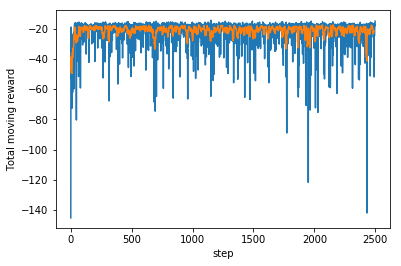

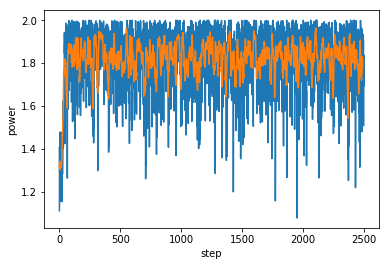

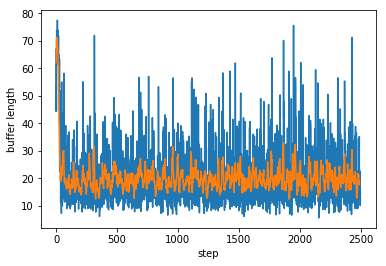

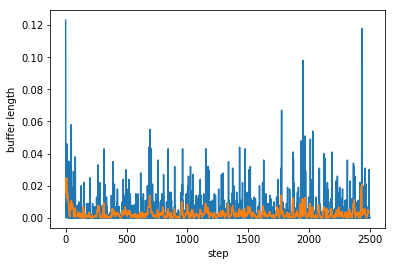

In [3]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

In [1]:
cur_init_ds_ep = env.reset()
    
cur_r_ep = np.zeros(len(user_list))
cur_p_ep = np.zeros(len(user_list))
cur_n_ep = np.zeros(len(user_list))
cur_ts_ep = np.zeros(len(user_list))
cur_rs_ep = np.zeros(len(user_list))
cur_ps_ep = np.zeros(len(user_list))
cur_ds_ep = np.zeros(len(user_list))
cur_ch_ep = np.zeros(len(user_list))
    
for j in range(1000):
    # first try to transmit from current state
    [cur_r, done, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
    cur_r_ep += cur_r
    cur_p_ep += cur_p
    cur_ts_ep += cur_ts
    cur_ps_ep += cur_ps
    cur_rs_ep += cur_rs
    cur_ds_ep += cur_ds
    cur_ch_ep += cur_ch
        
    print('%d:r:%f,p:%s,n:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (j, cur_r, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_init_ds_ep))
        
print('r:%f,p:%s,n:%s,tr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_n_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep))

NameError: name 'env' is not defined

In [3]:
graph = tf.get_default_graph()
inputs = graph.get_tensor_by_name("input_1"+":0")
scaled_out = graph.get_tensor_by_name("output_1"+":0")
print sess.run(scaled_out, feed_dict={inputs: [[7.22254768,2.3384,2.7784888e-05]]})

[[0.78826445 1.        ]]


In [2]:
res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit(False)
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])

0:r:-50.8910,p:1.4033,tr:1.4707,pr:1.3505,rev:2.9594,dbuf:72.5261,ch:0.00002568,ibuf:4
1:r:-57.9454,p:1.3913,tr:1.6529,pr:1.2218,rev:3.0360,dbuf:74.1439,ch:0.00002761,ibuf:30
2:r:-51.0844,p:1.1953,tr:1.5476,pr:1.2320,rev:2.8984,dbuf:73.1955,ch:0.00002990,ibuf:39
3:r:-18.2811,p:1.3469,tr:1.5860,pr:1.3673,rev:2.9762,dbuf:61.5868,ch:0.00002683,ibuf:35
4:r:-17.5547,p:1.2180,tr:1.7657,pr:1.2518,rev:3.0115,dbuf:55.9275,ch:0.00003238,ibuf:63
5:r:-55.6239,p:1.4116,tr:1.4240,pr:1.3390,rev:2.8791,dbuf:69.1011,ch:0.00002492,ibuf:48
6:r:-37.3900,p:1.2706,tr:1.3830,pr:1.5578,rev:3.0240,dbuf:59.5109,ch:0.00002915,ibuf:8
7:r:-32.6223,p:1.4738,tr:1.3452,pr:1.6902,rev:3.0674,dbuf:63.5657,ch:0.00002512,ibuf:71
8:r:-20.8140,p:1.2057,tr:1.4394,pr:1.5456,rev:3.0451,dbuf:49.6221,ch:0.00002902,ibuf:38
9:r:-19.3836,p:1.1973,tr:1.4459,pr:1.4838,rev:2.9358,dbuf:56.0717,ch:0.00002922,ibuf:86


In [3]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import ipdb as pdb
import time

MAX_EPISODE = 50
MAX_EPISODE_LEN = 1000

NUM_T = 1
NUM_R = 1
SIGMA2 = 0.3e-9

config = {'state_dim':3, 'action_dim':2};
train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                 'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                 'random_seed':1234}
user_config = [{'id':'1', 'rate':3, 'dis':100, 'action_bound':1, 
                'data_buf_size':100, 't_factor':0.9, 'penalty':1000}];

print user_config
# 0. initialize the session object
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
    
# 1. include all user in the system according to the user_config
user_list = [];
for info in user_config:
    info.update(config)
    user_list.append(MecTermLD(sess, info, train_config))
    print 'test'

# 2. create the simulation env
env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)
env.init_target_network()

res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])
sess.close()

[{'data_buf_size': 100, 'penalty': 1000, 'rate': 3, 'action_bound': 1, 'id': '1', 't_factor': 0.9, 'dis': 100}]
INFO:tensorflow:Restoring parameters from model/my_test_model
--Return--
None
> <ipython-input-3-a12846566f97>(30)<module>()
     29 graph = tf.get_default_graph()
---> 30 pdb.set_trace()
     31 

ipdb> graph
ipdb> graph.trainable_variables
*** AttributeError: 'Graph' object has no attribute 'trainable_variables'
ipdb> tf.trainable_variables()
[<tf.Variable 'fully_connected/weights:0' shape=(3, 400) dtype=float32_ref>, <tf.Variable 'fully_connected/BatchNorm/beta:0' shape=(400,) dtype=float32_ref>, <tf.Variable 'fully_connected_1/weights:0' shape=(3, 300) dtype=float32_ref>, <tf.Variable 'fully_connected_1/BatchNorm/beta:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'fully_connected_2/weights:0' shape=(300, 2) dtype=float32_ref>, <tf.Variable 'fully_connected_2/biases:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'fully_connected_3/weights:0' shape=(3, 400) dtype=float32

BdbQuit: 

In [9]:
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
variable_names = [v.name for v in tf.trainable_variables()]
values = sess.run(variable_names)
print sess.run('fully_connected_2/weights:0')

INFO:tensorflow:Restoring parameters from model/my_test_model
[[0.1545126  0.15780352]
 [0.15616506 0.15971294]
 [0.06559879 0.09880391]
 [0.06487427 0.10064688]
 [0.15168335 0.16229852]
 [0.06257845 0.09748891]
 [0.06430701 0.09924787]
 [0.06548443 0.10012874]
 [0.15782878 0.15414344]
 [0.15429462 0.17596859]
 [0.05945097 0.0991616 ]
 [0.06383383 0.09632684]
 [0.06522399 0.10438306]
 [0.06095436 0.09916781]
 [0.06635379 0.0955418 ]
 [0.06379106 0.09433711]
 [0.06133086 0.09875894]
 [0.06503102 0.09639146]
 [0.15047684 0.17412661]
 [0.15663381 0.15740666]
 [0.17768952 0.15899988]
 [0.15730077 0.14491995]
 [0.05902164 0.10017106]
 [0.06845198 0.09686822]
 [0.15724926 0.14774598]
 [0.1529071  0.16426612]
 [0.1520101  0.15706535]
 [0.16091335 0.16260217]
 [0.15082897 0.16070077]
 [0.06310375 0.09398151]
 [0.06018374 0.10056869]
 [0.05968894 0.10066012]
 [0.15474424 0.16255529]
 [0.15111688 0.1622602 ]
 [0.0838669  0.18973866]
 [0.06870251 0.24295035]
 [0.06702217 0.10505467]
 [0.1529     

In [3]:
np.save('t_08/1', [1])